# Student's Paired t-Test for Comparing Means

> Use Case: 
- Compare means of paired samples (e.g., before and after treatment) to determine if there is a significant difference.
> Assumptions:
- Data is approximately normally distributed.
- Differences between paired observations are independent and identically distributed.
> Example Scenario:
- Examining whether there is a significant improvement in test scores after a tutoring program.
> Null Hypothesis (H0):
- There is no significant difference in the means of the paired samples.
> Alternative Hypothesis (H1):
- There is a significant difference in the means of the paired samples.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import shapiro, ttest_rel, t

# !pip install statsmodels==0.12.2
from statsmodels.stats.power import TTestPower

# !pip install pingouin==0.5.4
import pingouin as pg

In [87]:
# Set random seed for reproducibility
np.random.seed(42)

In [88]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'seagreen'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:7702: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:7694: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


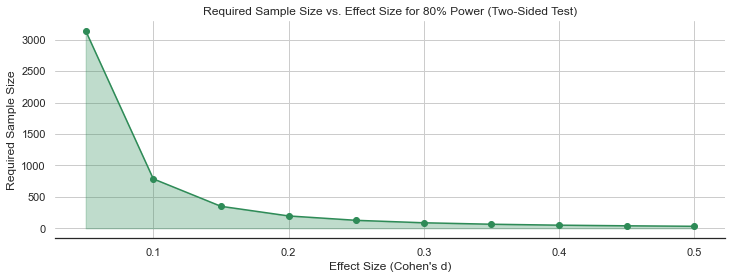

In [89]:
# Set the parameters for the power analysis
alpha = 0.05  # Significance level
desired_power = 0.8  # Desired statistical power

# Create an instance of the TTestPower class
power_analysis = TTestPower()

# Define the range of effect sizes to test
effect_sizes = np.linspace(0.05, 0.5, 10)  # Effect sizes from 0.1 to 1.0 in 10 increments

# Calculate the required sample size for each effect size
sample_sizes = []
for effect_size in effect_sizes:
    sample_size = power_analysis.solve_power(
        effect_size=effect_size, alpha=alpha, power=desired_power, alternative='two-sided'
    )
    sample_sizes.append(round(sample_size))  # Rounding to get an integer value

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 4))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Effect Size for 80% Power (Two-Sided Test)')
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Required Sample Size')
plt.grid(True)
plt.show()

In [90]:
# Set the parameters for the power analysis
effect_size = 0.1  # Cohen's d, the standardized effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired statistical power

# Create an instance of the TTestPower class
power_analysis = TTestPower()

# Calculate the required sample size per group
sample_size = int(np.ceil(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')))

# Print the result
print(f"Required sample size per group: {round(sample_size)}")

Required sample size per group: 787


### Synthetic Data

In [91]:
# Generate synthetic data for paired t-test
before_treatment = np.random.normal(loc=50, scale=10, size=sample_size)
after_treatment = before_treatment + np.random.normal(loc=5, scale=3, size=sample_size)

# Create pandas DataFrame
paired_t_test_data = pd.DataFrame({'Before Treatment': before_treatment, 'After Treatment': after_treatment})
paired_t_test_data

,Before Treatment,After Treatment
0,54.967142,61.344682
1,48.617357,53.406860
2,56.476885,56.494003
3,65.230299,71.519153
4,47.658466,53.281529
...,...,...
782,53.801979,57.214820
783,56.105857,63.488651
784,55.597904,56.835036
785,60.807807,66.688481


### Assumptions

In [92]:
# Assumption validation for paired t-test
def validate_paired_t_test_assumptions(data, alpha=0.05):
    # Calculate differences
    differences = data['After Treatment'] - data['Before Treatment']

    # Shapiro-Wilk test for normality of differences
    stat, p_value = shapiro(differences)
    print(f'Shapiro-Wilk Test (Normality of Differences): Statistic={stat}, p-value={p_value}')

    # Interpretation based on p-value
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nDifferences are not Normally distributed.')
    else:
        print(f'\nFail to reject the null hypothesis: \nDifferences are approximately Normally distributed.')

# Example usage for paired t-test data
validate_paired_t_test_assumptions(paired_t_test_data)

Shapiro-Wilk Test (Normality of Differences): Statistic=0.997674286713667, p-value=0.3427608779964512

Fail to reject the null hypothesis: 
Differences are approximately Normally distributed.


### Paired t-test (SciPy)

In [93]:
# Run paired t-test
def run_paired_t_test(data, alpha=0.05):
    
    res = ttest_rel(data['After Treatment'], data['Before Treatment'])
    stat, p_value = res
    dof = res.df
    print(f'Paired t-Test: Statistic: {stat}\np-value: {p_value}\nDegrees of Freedom: {dof}\n')

    lb, ub = ttest_rel(data['After Treatment'], data['Before Treatment']).confidence_interval(confidence_level=0.95)
    print(f'95% Confidence Interval for the Difference in Means: [{lb}, {ub}]')

    # Interpretation based on p-value
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between After Treatment and Before Treatment.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between After Treatment and Before Treatment.')

# Example usage for paired t-test data
run_paired_t_test(paired_t_test_data)

Paired t-Test: Statistic: 49.681131856526484
p-value: 1.0559452941256624e-244
Degrees of Freedom: 786

95% Confidence Interval for the Difference in Means: [5.073547688345016, 5.49096989458994]

Reject the null hypothesis: 
There is a significant difference between After Treatment and Before Treatment.


### Paired t-test (pingouin)

In [94]:
# Paired t-test
pg.ttest(paired_t_test_data['After Treatment'], paired_t_test_data['Before Treatment'], paired=True, alternative='two-sided', correction='auto', r=0.707, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,49.681132,786,two-sided,1.055945e-244,"[5.07, 5.49]",0.519281,3.486e+240,1.0


### 95% Confidence Interval

In [95]:

# Calculate the differences
differences = paired_t_test_data['After Treatment'] - paired_t_test_data['Before Treatment']

# Calculate the mean and standard deviation of the differences
mean_diff = differences.mean()
std_diff = differences.std(ddof=1)

# Calculate the sample size
n = len(differences)

# Calculate the standard error of the mean difference
se_diff = std_diff / np.sqrt(n)

# Calculate the critical t-value for a 95% confidence interval (two-sided)
critical_t = t.ppf(0.975, df=n-1)

# Calculate the margin of error
margin_of_error = critical_t * se_diff

# Calculate the 95% confidence interval
lower_bound = mean_diff - margin_of_error
upper_bound = mean_diff + margin_of_error

# Print results
print(f"Mean Difference: {mean_diff}")
print(f"95% Confidence Interval of the Mean Difference: [{lower_bound}, {upper_bound}]")

Mean Difference: 5.282258791467478
95% Confidence Interval of the Mean Difference: [5.073547688345016, 5.49096989458994]


### Effect Size

In [96]:
# Calculate means
mean_a = np.mean(paired_t_test_data['Before Treatment'])
mean_b = np.mean(paired_t_test_data['After Treatment'])

# Calculate standard deviations
std_a = np.std(paired_t_test_data['Before Treatment'], ddof=1)  # Using sample standard deviation
std_b = np.std(paired_t_test_data['After Treatment'], ddof=1)

# Calculate sample sizes
n_a = len(paired_t_test_data['Before Treatment'])
n_b = len(paired_t_test_data['After Treatment'])

# Calculate pooled standard deviation
s_pooled = np.sqrt(((n_a - 1) * std_a**2 + (n_b - 1) * std_b**2) / (n_a + n_b - 2))

# Calculate Cohen's d
d = (mean_b - mean_a) / s_pooled

print(f"Cohen's d Effect Size: {d} standard deviations")
print("\n")


if d >= 2:
    print("There is a huge difference between the two groups.")
elif d >= 1.2:
    print("There is a very large difference between the two groups.")
elif d >= 0.8:
    print("There is a large difference between the two groups.")
elif d >= 0.5:
    print("There is a moderate difference between the two groups.")
elif d >= 0.2:
    print("There is a small difference between the two groups.")
elif d >= 0.01:
    print("There is a very small difference between the two groups.")
else:
    print("There is no difference between the two groups.")


Cohen's d Effect Size: 0.519280821797478 standard deviations


There is a moderate difference between the two groups.


### Visualization

In [97]:
# Count everything up
total_count = paired_t_test_data.size
group_a_count = paired_t_test_data['Before Treatment'].count()
group_b_count = paired_t_test_data['After Treatment'].count()
group_a_mean = paired_t_test_data['Before Treatment'].mean()
group_b_mean = paired_t_test_data['After Treatment'].mean()
group_a_var= paired_t_test_data['Before Treatment'].var()
group_b_var = paired_t_test_data['After Treatment'].var()
group_a_std= paired_t_test_data['Before Treatment'].std()
group_b_std = paired_t_test_data['After Treatment'].std()

In [98]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Before Treatment", "After Treatment"],
    'Total': [group_a_count, group_b_count],
    'Mean Test Score': [group_a_mean, group_b_mean],
    'Variance': [group_a_var, group_b_var],
    'Standard Deviation': [group_a_std, group_b_std],
}, index=[0, 1])
plot_data

,Test Group,Total,Mean Test Score,Variance,Standard Deviation
0,Before Treatment,787,49.932013,97.385902,9.868430
1,After Treatment,787,55.214272,109.563787,10.467272


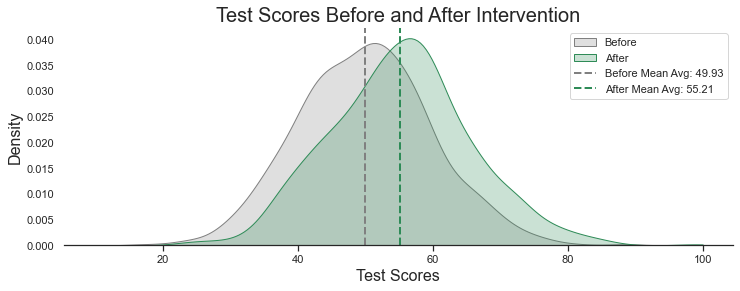

In [99]:
# Compare distributions of means between the two groups
plt.figure(figsize=(12, 4))
sns.kdeplot(paired_t_test_data['Before Treatment'], label='Before', fill = True, color = 'grey', clip=(0, 100) )
sns.kdeplot(paired_t_test_data['After Treatment'], label='After', fill = True, color = color, clip=(0, 100) )
mean_group_a = paired_t_test_data['Before Treatment'].mean()
mean_group_b = paired_t_test_data['After Treatment'].mean()
plt.axvline(mean_group_a, color='grey', linestyle='dashed', linewidth=2, label=f'Before Mean Avg: {mean_group_a:.2f}')
plt.axvline(mean_group_b, color=color, linestyle='dashed', linewidth=2, label=f'After Mean Avg: {mean_group_b:.2f}')
plt.title('Test Scores Before and After Intervention', fontsize = 20)
plt.xlabel('Test Scores', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.legend()
plt.show()